# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)


In [15]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f67925af-5aa8-2036-53a8-4a804d3c69b9)


## Model Selection




## Feature Engineering



In [16]:
# Load the dataset
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

drive.mount('/content/drive')

path = "/content/drive/MyDrive/Forcasting based on Energy Charts datasets/Energy_Charts_2025_to_2024.csv"

df = (
    pd.read_csv(path, low_memory=False)
      .fillna(0)
      .query("`Date (GMT+1)` == `Date (GMT+1)`")  # filter notna()
)
df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)
df = df.set_index(['Date (GMT+1)'])

# Target: Day Ahead Auction (DE-LU)
target_col = 'Day Ahead Auction (DE-LU)'
ts_data = df[target_col].astype(np.float32)

# Features: all numeric columns (including target)
features = df.astype(np.float32).values
target = ts_data.values

n_features = features.shape[1]
look_back = 5  # same as before
horizon = 1    # predict 1 step ahead






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-440438581.py:15: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)
/tmp/ipython-input-440438581.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)


In [17]:
def window_multivariate(features, target, look_back, horizon=1):
    X, y = [], []
    for i in range(len(features) - look_back - horizon + 1):
        X.append(features[i:i+look_back])          # all features over look_back
        y.append(target[i+look_back + horizon-1])  # price at forecast step
    return np.array(X), np.array(y)

X, y = window_multivariate(features, target, look_back, horizon)

print("X shape (samples, look_back, n_features):", X.shape)
print("y shape:", y.shape)

# Flatten time + feature dims for N-BEATS (fully connected)
X_flat = X.reshape(X.shape[0], -1)
input_dim = X_flat.shape[1]
print("X_flat shape:", X_flat.shape)

X shape (samples, look_back, n_features): (70171, 5, 23)
y shape: (70171,)
X_flat shape: (70171, 115)


In [18]:
# Train-test split
train_ratio = 0.8
train_size = int(train_ratio * len(X_flat))

X_train, X_test = X_flat[:train_size], X_flat[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Train size:", train_size)
print("Test size:", len(X_flat) - train_size)



Train size: 56136
Test size: 14035


## Hyperparameter Tuning




In [19]:
# Implement hyperparameter tuning
def nbeats_block(
    inputs,
    units=256,
    theta_dim=64,
    name_prefix="block"
):
    """
    Simple N-BEATS-style block:
    - Fully connected stack
    - Outputs theta
    - Theta mapped to backcast & forecast via linear layers
    """
    x = inputs
    for i in range(4):
        x = layers.Dense(units, activation="relu", name=f"{name_prefix}_fc{i+1}")(x)

    theta = layers.Dense(theta_dim, activation="linear", name=f"{name_prefix}_theta")(x)

    # For horizon=1, forecast_dim = 1
    # Backcast dimension = input_dim (we reconstruct the input space)
    backcast = layers.Dense(input_dim, activation="linear", name=f"{name_prefix}_backcast")(theta)
    forecast = layers.Dense(horizon, activation="linear", name=f"{name_prefix}_forecast")(theta)

    return backcast, forecast

def build_nbeats_model(input_dim, horizon=1, n_stacks=3, units=256, theta_dim=64):
    inputs = keras.Input(shape=(input_dim,), name="nbeats_input")

    residual = inputs
    forecasts = []

    for i in range(n_stacks):
        backcast, forecast = nbeats_block(
            residual,
            units=units,
            theta_dim=theta_dim,
            name_prefix=f"stack{i+1}"
        )
        residual = layers.Subtract(name=f"stack{i+1}_residual")([residual, backcast])
        forecasts.append(forecast)

    # Sum forecasts from all stacks
    y_hat = layers.Add(name="forecast_sum")(forecasts)

    model = keras.Model(inputs=inputs, outputs=y_hat, name="NBEATS")
    return model


## Implementation




In [20]:
# Implement the final model(s)

model = build_nbeats_model(input_dim=input_dim, horizon=horizon, n_stacks=3, units=256, theta_dim=64)
model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mse"]
)

model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=2
)



Model: "NBEATS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ nbeats_input        │ (None, 115)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_fc1 (Dense)  │ (None, 256)       │     29,696 │ nbeats_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_fc2 (Dense)  │ (None, 256)       │     65,792 │ stack1_fc1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_fc3 (Dense)  │ (None, 256)       │     65,792 │ stack1_fc2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_fc4 (Dense)  │ (None, 256)       │     65,792 │ stack1_fc3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_theta        │ (None, 64)        │     16,448 │ stack1_fc4[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_backcast     │ (None, 115)       │      7,475 │ stack1_theta[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_residual     │ (None, 115)       │          0 │ nbeats_input[0][… │
│ (Subtract)          │                   │            │ stack1_backcast[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack2_fc1 (Dense)  │ (None, 256)       │     29,696 │ stack1_residual[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack2_fc2 (Dense)  │ (None, 256)       │     65,792 │ stack2_fc1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack2_fc3 (Dense)  │ (None, 256)       │     65,792 │ stack2_fc2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack2_fc4 (Dense)  │ (None, 256)       │     65,792 │ stack2_fc3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack2_theta        │ (None, 64)        │     16,448 │ stack2_fc4[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack2_backcast     │ (None, 115)       │      7,475 │ stack2_theta[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack2_residual     │ (None, 115)       │          0 │ stack1_residual[… │
│ (Subtract)          │                   │            │ stack2_backcast[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack3_fc1 (Dense)  │ (None, 256)       │     29,696 │ stack2_residual[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack3_fc2 (Dense)  │ (None, 256)       │     65,792 │ stack3_fc1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack3_fc3 (Dense)  │ (None, 256)       │     65,792 │ stack3_fc2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack3_fc4 (Dense)  │ (None, 256)       │     65,792 │ stack3_fc3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack3_theta        │ (None, 64)        │     16,448 │ stack3_fc4[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack1_forecast     │ (None, 1)         │         65 │ stack1_theta[0][

 Total params: 745,705 (2.84 MB)

 Trainable params: 745,705 (2.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
395/395 - 12s - 30ms/step - loss: 18314380.0000 - mse: 18314380.0000 - val_loss: 13197.9697 - val_mse: 13197.9697
Epoch 2/50
395/395 - 2s - 4ms/step - loss: 2911.8586 - mse: 2911.8586 - val_loss: 10862.8418 - val_mse: 10862.8418
Epoch 3/50
395/395 - 2s - 4ms/step - loss: 1945.6033 - mse: 1945.6033 - val_loss: 10148.1045 - val_mse: 10148.1045
Epoch 4/50
395/395 - 2s - 4ms/step - loss: 1420.3735 - mse: 1420.3735 - val_loss: 9580.5176 - val_mse: 9580.5176
Epoch 5/50
395/395 - 2s - 6ms/step - loss: 1326.9675 - mse: 1326.9675 - val_loss: 9630.9658 - val_mse: 9630.9658
Epoch 6/50
395/395 - 2s - 5ms/step - loss: 1255.1313 - mse: 1255.1313 - val_loss: 9343.7588 - val_mse: 9343.7588
Epoch 7/50
395/395 - 2s - 4ms/step - loss: 1449.7130 - mse: 1449.7130 - val_loss: 9643.0479 - val_mse: 9643.0479
Epoch 8/50
395/395 - 2s - 4ms/step - loss: 3074.4424 - mse: 3074.4424 - val_loss: 9262.4453 - val_mse: 9262.4453
Epoch 9/50
395/395 - 2s - 4ms/step - loss: 4562.8145 - mse: 4562.8145 - val_loss

## Evaluation Metrics

We evaluate the model using R², MSE, RMSE, and MAE. These metrics capture different aspects of forecasting performance:




In [21]:
# Evaluate the model using your chosen metrics
# Metrics
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)

# MAPE with zero-safe mask
mask = y_test != 0
mape_test = mean_absolute_percentage_error(y_test[mask], y_test_pred[mask])

print("=== N-BEATS Performance ===")
print("Train R²:", r2_train)
print("Test R²:", r2_test)
print("Test MSE:", mse_test)
print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)



1755/1755 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== N-BEATS Performance ===
Train R²: 0.756476640701294
Test R²: 0.8686797618865967
Test MSE: 565.992431640625
Test RMSE: 23.790595445272594
Test MAE: 13.880828857421875


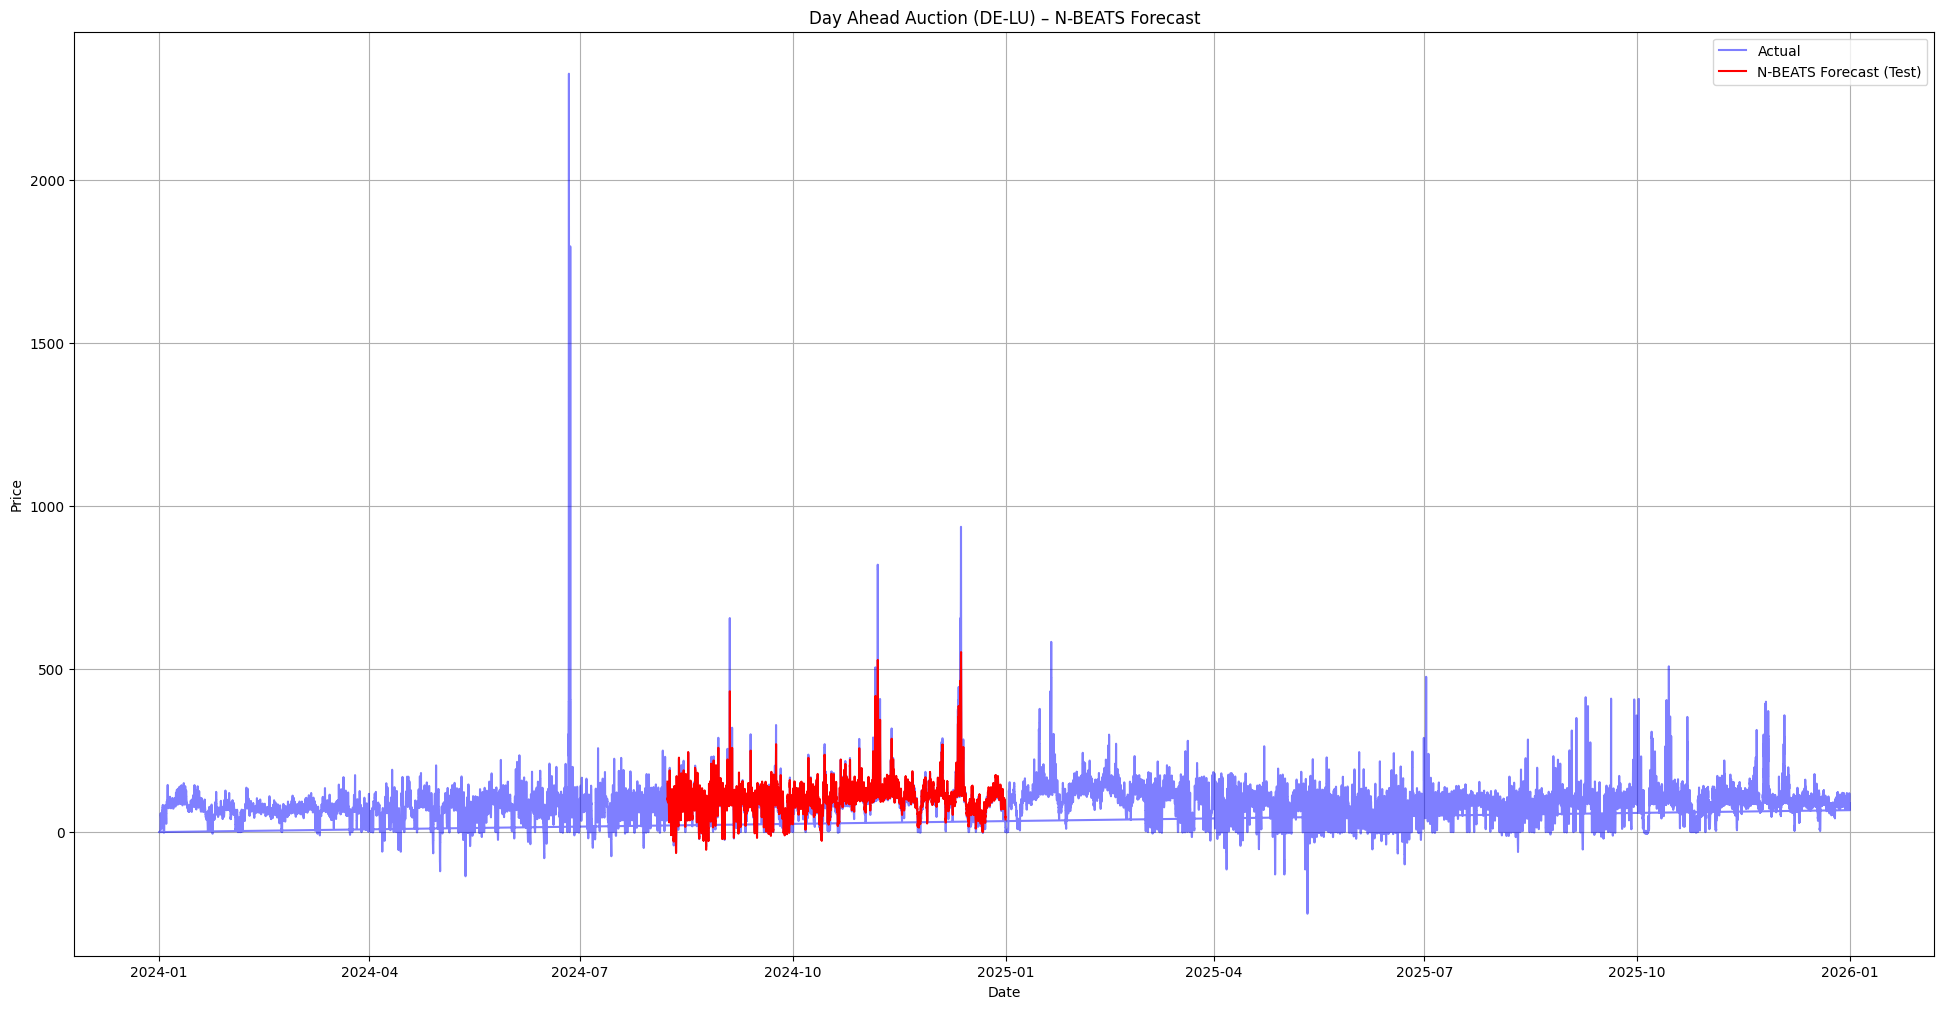

In [22]:
date_range = df.index
ts_full = ts_data.values

test_start_idx = train_size + look_back + horizon - 1
test_dates = date_range[test_start_idx : test_start_idx + len(y_test_pred)]

plt.figure(figsize=(24, 12))
plt.plot(date_range, ts_full, label="Actual", color="blue", alpha=0.5)
plt.plot(test_dates, y_test_pred, label="N-BEATS Forecast (Test)", color="red")
plt.title("Day Ahead Auction (DE-LU) – N-BEATS Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

## Comparative Analysis

The LSTM achieves the best performance overall, with an R² of 0.88 and significantly lower errors than both SARIMAX and XGBoost. Its MSE (331) and RMSE (18.19) show that it captures the temporal patterns in the data far more effectively, making it the strongest forecasting model in this comparison.

XGBoost  
MSE: 1358.9230238188288  
RMSE: 36.86357312875176   

Baseline Model (SARIMAX)
MSE: 1424.2550828672138    
RMSE: 37.7393042181121  

LSTM_GRU
R²: 0.8836387915795975  
MSE: 331.0454052959218  
RMSE: 18.194653206256003  
MAE: 13.079722743312484  

N-Beats
R²: -0.3709542751312256  
MSE: 3900.338623046875  
RMSE: 62.45269107930318  
MAE: 52.551902770996094  
